In the [previous post]({% post_url 2020-07-18-ppo %}) we covered **proximal policy optimization** (PPO). We used a surrogate loss which is a lower bound on the policy performance $\eta$ which allowed us to use multiple updates per gradient step. We also used clipping to ensure the policy did not stray too far from the old policy at each gradient step and stopped doing gradient steps when their KL divergence exceeds some threshold.

## Deep $Q$-Learning for Continuous Action Spaces

When we originally covered [vanilla $Q$-learning]({% post_url 2020-05-26-q-learning %}), we used dynamic programming to learn the $Q$-function using the Bellman Equation. This worked because we had a small discrete state space and a small discrete action space.

We then extended $Q$-learning to continuous state spaces by using function approximation to learn the $Q$-function. We used a neural network to do this. Recall that the greedy policy used by (deep) $Q$-learning is

$$
a_t = \arg \max_{a_t} Q^*(s_t, a_t)
$$

This was still feasible using a neural network with a relatively small action space, since we could just have one output for each action at the end of the neural network and use each of these outputs to estimate $Q^*(s_t, a_t)$. 

We face a problem when we try to use deep $Q$-learning with continuous action spaces, where actions are represented by real-valued vectors. Solving for the arg max is an expensive inner optimization procedure that would have to be done every time the agent takes a step. While this is hypothetically feasible, we ideally want agents that can perform well in realistic real-time scenarios such as video game playing and robotics.

In the original [DQN setting]({% post_url 2020-05-31-dqn %}), our neural network took in a state $s_t$ and produced one output for each action in the action space. We did this instead of having the network accept both the state and action to produce a scalar to avoid multiple forward passes through the network (one for each action).

However, if we want to use continuous action spaces, we will need to reconfigure our deep $Q$-network to accept both the state $s_t$ and action $a_t$ to produce a scalar output, the prediction for $Q^*(s_t, a_t)$.

Because the action space is continuous, we now assume that the $Q$-function is differentiable with respect to the action as well as the state. We define a **deterministic policy** $\mu_\theta$ with parameter vector $\theta$ that maps states directly to the continuous action space (i.e., $\mu_\theta$ is vector-valued). Then, instead of running an inner optimization procedure to select $\max_{a_t} Q^*(s_t, a_t)$, we approximate

$$
\max_{a_t} Q^*(s_t, a_t) \approx Q^*(s_t, \mu_\theta(s_t))
$$

(i.e., we assume $\mu_\theta(s_t)$ is the optimal action). 

Like in DQN, we use a neural network $Q_\phi$ to estimate $Q^*$. Recall the $Q$-learning loss for DQN:

$$
L(\phi) = \mathbb{E}_\tau \left[ \left(Q_\phi(s_t, a_t) - \left(r_t + \gamma (1 - d_t) \max_{a_{t+1}} Q_\phi(s_{t+1}, a_{t+1}) \right) \right)^2 \right]
$$

Like in DQN, we will use a **replay buffer** $\mathcal{D}$ to store previous experience and stabilize training. 

We will also use **target networks**. In DQN, we used a target network $Q_{\phi}^-$ to generate the target value

$$
r_t + \gamma (1 - d_t) \max_{a_{t+1}} Q_\phi^- (s_{t+1}, a_{t+1})
$$

In DQN the target network has frozen parameters that get updated to match those of $Q_\phi$. Unlike in DQN where we just update the parameters every $n_\theta$ time steps, we can instead use **Polyak averaging**:

$$
\theta^- \gets \rho \theta^- + (1-\rho) \theta
$$

where $\rho$ is a parameter close to 1. This is essentially a step along a linear interpolation between parameter vectors.

Now, given our approximation $\max_{a_t} Q^*(s_t, a_t) \approx Q^*(s_t, \mu(s_t))$, we update the $Q$-learning loss:

$$
L(\phi) = \mathbb{E}_\tau \left[ \left(Q_\phi(s_t, a_t) - \left(r_t + \gamma (1 - d_t) Q_\phi^-(s_{t+1}, \mu_\theta(s_{t+1}) \right) \right)^2 \right]
$$

Finally, just how we use target networks for $Q_\phi$ to stabilize training, we also use target networks for $\mu_\theta$ in the target to stabilize training.

Our final loss function looks like

$$
L(\phi) = \mathbb{E}_\tau \left[ \left(Q_\phi(s_t, a_t) - \left(r_t + \gamma (1 - d_t) Q_\phi^-(s_{t+1}, \mu_\theta^-(s_{t+1}) \right) \right)^2 \right]
$$

where $\mu_\theta^-$ is the target policy. Again, we us Polyak averaging at each time step:

$$
\theta^- \gets \rho \theta^- + (1-\rho) \theta
$$

In the regular policy gradient regime, we train our policy $\mu_\theta$ to maximize the expected return:

$$
\begin{align}
L(\theta) &= \mathbb{E}_\tau \left[ G_t \right] \\
&= \mathbb{E}_\tau \left[ Q^*(s_t, a_t) \right] \\
&\approx \mathbb{E}_\tau \left[ Q_\phi (s_t, \mu_\theta(s_t)) \right] \\
\end{align}
$$

If we treat the neural network $Q_\phi$ as a "constant" operation on the action $\mu_\theta(s_t)$, then we can just use this neural network to try to maximize the expected return. We call this technique **deep deterministic policy gradients** or DDPG.

We learn by interleaving training the $Q_\phi$ with training the policy $\mu_\theta$.

Because the $Q$-learning loss can use any state transition, the learning is actually done **off-policy** unlike previous policy gradient methods like REINFORCE, A2C and PPO which are **on-policy** algorithms.

Unlike in previous posts where continuous control was achieved by outputting the mean of a diagonal Gaussian distribution and then sampling from that, in this algorithm the policy is **deterministic**. This means that initial exploration may be poor, leading to poor learning by the $Q$-network. There are several approaches to solving this, but the easiest is to add Gaussian noise to the action during training to "smooth out" the learned $Q$-function, and then remove the noise at testing time.

In [1]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, batch_size=32, size=1000000):
        '''
        batch_size (int): number of data points per batch
        size (int): size of replay buffer.
        '''
        self.batch_size = batch_size
        self.memory = deque(maxlen=size)
        
        self.states = np.zeros()

    def remember(self, s_t, a_t, r_t, s_t_next, d_t):
        '''
        s_t (np.ndarray double): state
        a_t (np.ndarray int): action
        r_t (np.ndarray double): reward
        d_t (np.ndarray float): done flag
        s_t_next (np.ndarray double): next state
        '''
        self.memory.append((s_t, a_t, r_t, s_t_next, d_t))

    def sample(self):
        '''
        random sampling of data from buffer
        '''
        # if we don't have enough samples yet
        size = min(self.batch_size, len(self.memory))
        return random.sample(self.memory, size)

In [2]:
import copy
import numpy as np
import gym

class VectorizedEnvWrapper(gym.Wrapper):
    def __init__(self, env, num_envs=1):
        '''
        env (gym.Env): to make copies of
        num_envs (int): number of copies
        '''
        super().__init__(env)
        self.num_envs = num_envs
        self.envs = [copy.deepcopy(env) for n in range(num_envs)]
    
    def reset(self):
        '''
        Return and reset each environment
        '''
        return np.asarray([env.reset() for env in self.envs])
    
    def step(self, actions):
        '''
        Take a step in the environment and return the result.
        actions (torch.tensor)
        '''
        next_states, rewards, dones = [], [], []
        for env, action in zip(self.envs, actions):
#             next_state, reward, done, _ = env.step(action.item())
            next_state, reward, done, _ = env.step(action.detach().numpy())
            if done:
                next_states.append(env.reset())
            else:
                next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)
        return np.asarray(next_states), np.asarray(rewards), \
            np.asarray(dones)

In [3]:
import torch

class Policy:
    def __init__(self, env, mu_lr=1e-2, Q_lr=1e-2, gamma=0.99):
        '''
        env (gym.Env): the environment
        lr (float): learning rate
        '''
        self.N = env.observation_space.shape[0]
        self.M = env.action_space.shape[0]
        self.gamma = gamma

        # policy network
        self.mu = torch.nn.Sequential(
            torch.nn.Linear(self.N, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, self.M)
        ).double()
        
        with torch.no_grad():
            torch.nn.init.normal_(self.mu[-1].weight, mean=0, std=1e-2)
            torch.nn.init.normal_(self.mu[-1].bias, mean=0, std=1e-2)
        
        self.mu_ = copy.deepcopy(self.mu)

        self.mu_opt = torch.optim.Adam(self.mu.parameters(), lr=mu_lr)

        # Q network
        self.Q = torch.nn.Sequential(
            torch.nn.Linear(self.N+self.M, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        ).double()

        with torch.no_grad():
            torch.nn.init.normal_(self.Q[-1].weight, mean=0, std=1e-2)
            torch.nn.init.normal_(self.Q[-1].bias, mean=0, std=1e-2)
            
        self.Q_ = copy.deepcopy(self.Q)

        self.Q_opt = torch.optim.Adam(self.Q.parameters(), lr=Q_lr)
    
    def act(self, s_t, alpha=1, beta=0):
        '''
        s_t (np.ndarray): the current state
        alpha (float): action coefficinet
        beta (float): noise coefficient
        
        alpha=0 beta=1 corresponds to random action
        alpha=1 beta=0 corresponds to deterministic action
        Because of environment vectorization, this will produce
        E actions where E is the number of parallel environments.
        '''
        s_t = torch.as_tensor(s_t).double()
        a_t = self.mu(s_t)
        
        eps_mu = torch.zeros_like(a_t)
        eps_sigma = torch.ones_like(a_t)
        eps = torch.distributions.Normal(eps_mu, eps_sigma).sample()
        
        return alpha*a_t + beta*eps
    
    def synchronize(self, A, B, rho):
        '''
        Shift A towards B by (1-rho)
        '''
        for a, b in zip(A, B):
            if hasattr(a, 'weight'):
                a.weight.data = rho*a.weight.data + (1-rho)*b.weight.data
            if hasattr(a, 'bias'):
                a.bias.data = rho*a.bias.data + (1-rho)*b.bias.data
                
    def synchronize_Q(self, rho=0.99):
        self.synchronize(self.Q_, self.Q, rho)
        
    def synchronize_mu(self, rho=0.99):
        self.synchronize(self.mu_, self.mu, rho)
        
    def learn_Q(self, states, actions, rewards, dones, next_states):
        '''
        ################# 
        '''

        states = torch.as_tensor(states)
        actions = torch.as_tensor(actions)
        rewards = torch.as_tensor(rewards)
        dones = torch.as_tensor(dones)
        next_states = torch.as_tensor(next_states)
        
#         print(f'''
#         states.shape: {states.shape}
#         actions.shape: {actions.shape}
#         rewards.shape: {rewards.shape}
#         dones.shape: {dones.shape}
#         ''')

        next_actions = self.mu_(states).detach()
        target_inputs = torch.cat((next_states, next_actions), dim=-1)
        
#         print(f'''
#         target_inputs.shape: {target_inputs.shape}
#         ''')
        
        with torch.no_grad():
            Q_targ = self.Q_(target_inputs)
#             print(f'''
#             Q_targ.shape: {Q_targ.shape}
#             ''')
            Q_targ = Q_targ.squeeze()
#             print(f'''
#             Q_targ.shape (squeezed): {Q_targ.shape}
#             ''')
            target = rewards + (1-dones)*self.gamma*Q_targ
            
#         print(f'''
#         target.shape: {target.shape}
#         target: {target}
#         ''')

        inputs = torch.cat((states, actions), dim=-1)
        Q_pred = self.Q(inputs).squeeze()
        
#         print(f'''
#         Q_pred.shape: {Q_pred.shape}
#         Q_pred: {Q_pred}
#         ''')
        
#         print(f'''
#         diff: {target - Q_pred}
#         ''')
        
        loss = torch.mean((target - Q_pred)**2)
        
#         print(f'''
#         loss: {loss}
#         ''')

        self.Q_opt.zero_grad()
        loss.backward()
        self.Q_opt.step()
    
    def learn_pi(self, states):
        '''
        #####################
        '''
        states = torch.as_tensor(states)
        actions = self.mu(states)

        inputs = torch.cat((states, actions), dim=-1)
        Q_pred = self.Q(inputs).squeeze()
        loss = torch.mean(-Q_pred)

        self.Q_opt.zero_grad()
        self.mu_opt.zero_grad()
        loss.backward()
        self.mu_opt.step()
        
    def update(self, states, actions, rewards, dones, next_states, rho):
        states = torch.as_tensor(states).double()
        actions = torch.as_tensor(actions).double()
        rewards = torch.as_tensor(rewards).double()
        dones = torch.as_tensor(dones).double()
        next_states = torch.as_tensor(next_states).double()
        
        
        self.learn_Q(states, actions, rewards, dones, next_states)
        self.learn_pi(states)
        self.synchronize_Q(rho)
        self.synchronize_mu(rho)

In [6]:
import seaborn as sns; sns.set()

def DDPG(env, agent, 
        gamma=0.99,
         rho=0.99,
         batch_size=128,
         start_steps=1000,
         T=4052):    
    
    states = np.empty((T, env.num_envs, agent.N))
    actions = np.empty((T, env.num_envs, agent.M))
    rewards = np.empty((T, env.num_envs))
    dones = np.empty((T, env.num_envs))
    next_states = np.empty((T, env.num_envs, agent.N))
    
    # for plotting
    totals = []
    episode_rewards = 0
    
    s_t = env.reset()
    
    for t in range(start_steps):
        a_t = agent.act(s_t, 0, 1) # random action
        s_t_next, r_t, d_t = env.step(a_t)

        states[t] = s_t
        actions[t] = a_t.detach().numpy()
        rewards[t] = r_t
        dones[t] = d_t
        next_states[t] = s_t_next
        
        s_t = s_t_next
    
    for t in range(start_steps, T):
        env.envs[0].render()
        a_t = agent.act(s_t, 1, 0.99**t)
        s_t_next, r_t, d_t = env.step(a_t)

        states[t] = s_t
        actions[t] = a_t.detach().numpy()
        rewards[t] = r_t
        dones[t] = d_t
        next_states[t] = s_t_next
        
        batch_indices = np.random.randint(low=0, high=min(t, batch_size), size=batch_size)

        assert not np.isnan(states[batch_indices]).any()
        assert not np.isnan(actions[batch_indices]).any()
        assert not np.isnan(rewards[batch_indices]).any()
        assert not np.isnan(dones[batch_indices]).any()
        assert not np.isnan(next_states[batch_indices]).any()
        
        agent.update(
            states[batch_indices],
            actions[batch_indices],
            rewards[batch_indices],
            dones[batch_indices],
            next_states[batch_indices],
            rho
        )

        episode_rewards += r_t
        for i in range(env.num_envs):
            if d_t[i]:
                totals.append(episode_rewards[i])
                episode_rewards[i] = 0
                print(totals[-1])
                
        s_t = s_t_next
        
    sns.lineplot(x=range(len(totals)), y=totals)

-348.02563
-359.87115
-78.21835
-75.618996
-460.4314
-422.79968
-445.17493
-437.3375
-430.15292
-436.42502
-40.50836
-41.222717
-40.521145
-40.508446
-40.507473
-40.515892
-35.216454
-35.260998
-32.19941
-32.19941
-32.19941
-32.19941
-32.19941
-32.19941
-125.712364
-125.626144
-80.26696
-80.26369
-80.263466
-80.26414
-80.26867
-80.26432
-98.51779
-98.520775
-90.68598
-90.68446
-90.684235
-90.686035
-90.69001
-90.685234
-46.39398
-46.394043
-42.65688
-42.656864
-42.656452
-42.656693
-42.656803
-42.65652
-71.69356
-71.69379
-66.78399
-66.78377
-66.783806
-66.78398
-66.784004
-66.78386
-30.180841
-30.180841
-30.180841
-30.180841
-30.180841
-30.180841
-30.180841
-30.180841
-32.221382
-32.22143
-33.360973
-33.360992
-33.361073
-33.361034
-33.36102
-33.360977
-31.599518
-31.599592
-30.595911
-30.595882
-30.595898
-30.595892
-30.595911
-30.595911
-35.659332
-35.659332
-35.659332
-35.659332
-35.659332
-35.659332
-35.659332
-35.659332
-25.506273
-25.506273
-25.506273
-25.506273
-25.506273
-25.5

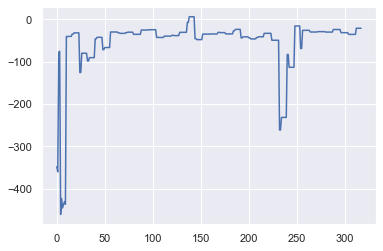

In [7]:
import gym_cartpole_swingup
env = VectorizedEnvWrapper(gym.make("CartPoleSwingUp-v0"), num_envs=8)
agent = Policy(env, mu_lr=0.01, Q_lr=0.01, gamma=0.999)
DDPG(env, agent, start_steps=2)